In [62]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime, timedelta
from geopy import distance

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


In [63]:
# load the pickle file
train_cleaned = pd.read_pickle('../datasets/train_cleaned.pkl')

In [64]:
train_cleaned.shape

(1296675, 32)

In [65]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'dob_year', 'trans_year', 'trans_month',
       'trans_week', 'trans_day', 'trans_hour', 'trans_minute',
       'trans_dayofweek', 'age', 'distance'],
      dtype='object')

In [66]:
train_cleaned[['city','city_pop']].sort_values('city')

,city,city_pop
838198,Achille,608
1218732,Achille,608
476783,Achille,608
868717,Achille,608
907989,Achille,608
...,...,...
1165421,Zavalla,2836
978857,Zavalla,2836
1225217,Zavalla,2836
927991,Zavalla,2836


In [67]:
train_cleaned['city'].nunique() , train_cleaned['city_pop'].nunique()

(894, 879)

In [68]:
# One glance view of the datasets - Super Imbalance Datasets
train_cleaned['is_fraud'].value_counts(normalize=True)

0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

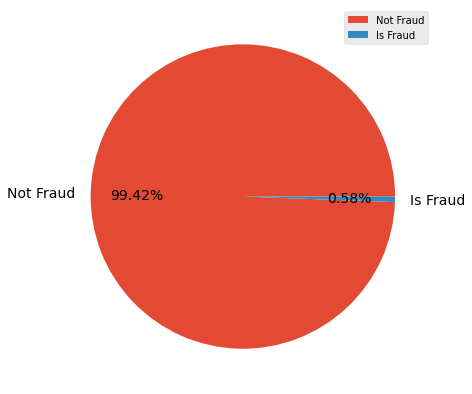

In [69]:
plt.figure(figsize=(7,7))
plt.pie(train_cleaned['is_fraud'].value_counts(normalize=True), 
         labels = ['Not Fraud','Is Fraud'], autopct='%.2f%%', pctdistance=0.7, textprops={'fontsize': 14})
plt.legend();

In [70]:
# check transctions that occur same time by same credit card
train_cleaned.groupby(['cc_num','is_fraud','trans_datetime'])['cc_num'].count()\
[train_cleaned.groupby(['cc_num','is_fraud','trans_datetime'])['cc_num'].count()>1]

cc_num               is_fraud  trans_datetime     
581686439828         0         2019-08-26 21:47:51    2
630423337322         0         2019-12-08 14:36:51    2
676173792455         0         2019-12-14 01:11:03    2
180036456789979      0         2019-08-11 19:26:21    2
374930071163758      0         2019-06-16 23:58:35    2
375082648741747      0         2019-06-28 21:25:50    2
2383461948823908     0         2019-12-06 08:43:10    2
3506042666828517     0         2019-04-18 17:32:31    2
3517527805128735     0         2020-03-14 02:15:53    2
3533012926413100     0         2020-05-21 15:52:29    2
3553629419254918     0         2019-03-10 02:31:27    2
3560318482131952     0         2019-10-31 01:16:14    2
3595192916105588     0         2019-01-16 05:51:27    2
4904681492230012     0         2020-03-15 00:34:58    2
4933461930348832     0         2019-04-14 16:33:06    2
6011504998544485     0         2019-09-23 16:43:49    2
6011652924285713     0         2020-06-02 20:14:33   

No Fraud Transaction is found from the transactions that occur at the same time by using the same credit card

In [71]:
train_cleaned['trans_datetime'].nunique()

1274791

In [72]:
train_cleaned['trans_num'].nunique()

1296675

In [73]:
train_cleaned.shape[0]

1296675

In [74]:
train_cleaned[(train_cleaned['trans_datetime'] == '2019-08-26 21:47:51')].iloc[:2,10:25]

,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,name,coords_ori,coords_merch,dob_year,trans_year,trans_month
561464,41.5205,-80.0573,5507,Retail merchandiser,1973-07-28,40ac37308bedf03151c99cd8693601d0,41.146578,-79.358042,0,Larry House,"(41.5205, -80.0573)","(41.146578000000005, -79.358042)",1973,2019,8
561465,41.5205,-80.0573,5507,Retail merchandiser,1973-07-28,8be3dfbb7768fd987916547b0c87698b,40.783844,-80.687971,0,Larry House,"(41.5205, -80.0573)","(40.783844, -80.68797099999999)",1973,2019,8


In [75]:
train_cleaned['amt_group'] = pd.qcut(train_cleaned['amt'], [0, 0.2, 0.5, 0.75, 0.9, 1])

In [76]:
train_cleaned['amt_group'].value_counts().sort_index().to_frame().reset_index()

,index,amt_group
0,"(0.999, 7.75]",259679
1,"(7.75, 47.52]",388733
2,"(47.52, 83.14]",324151
3,"(83.14, 136.67]",194454
4,"(136.67, 28948.9]",129658


In [77]:
train_cleaned.head(2)

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,amt_group
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin,_Kub_and_Mann",misc_net,4.97,F,561 Perry Cove,Moravian_Falls,NC,28654,...,2019,1,1,1,0,0,1,31,78.773821,"(0.999, 7.75]"
1,2019-01-01 00:00:44,630423337322,"fraud_Heller,_Gutmann_and_Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,...,2019,1,1,1,0,0,1,41,30.216618,"(83.14, 136.67]"


In [78]:
fraud_pct = train_cleaned.groupby(['amt_group','is_fraud'])['amt_group'].count().to_frame().unstack().reset_index()['amt_group']

In [79]:
fraud_pct['pct_of_fraud'] = fraud_pct[1] / (fraud_pct[1] + fraud_pct[0]) *100

In [80]:
fraud_pct.rename(columns= {'':'amt_group'},  inplace=True)

In [81]:
fraud_pct

is_fraud,amt_group,0,1,pct_of_fraud
0,"(0.999, 7.75]",259504,175,0.067391
1,"(7.75, 47.52]",387343,1390,0.357572
2,"(47.52, 83.14]",324070,81,0.024988
3,"(83.14, 136.67]",194318,136,0.069939
4,"(136.67, 28948.9]",123934,5724,4.414691


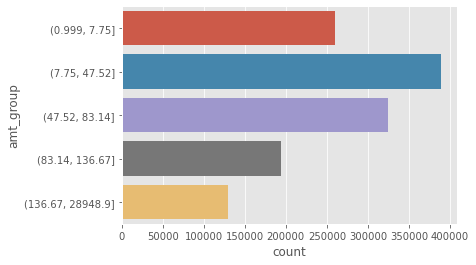

In [82]:
sns.countplot(data=train_cleaned, y='amt_group', orient='h');

In [83]:
# try categorize base on product category instead of overall amount

In [84]:
train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index()

,long,lat,amt,city_pop
0,-165.6723,64.7556,64.013967,145.0
1,-156.2920,65.6899,67.484944,277.0
2,-155.4880,20.0827,62.384971,4878.0
3,-155.3697,20.0271,56.714957,1490.0
4,-153.9940,66.6933,650.606667,239.0
...,...,...,...,...
965,-69.9576,44.3229,53.452626,6025.0
966,-69.4828,44.0943,60.136844,1643.0
967,-69.2675,44.8393,58.848150,3228.0
968,-68.5565,44.2541,100.042968,824.0


In [85]:
train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index()['amt'].describe()

count    970.000000
mean     110.680467
std      146.504632
min       42.951671
25%       61.071510
50%       67.543395
75%       87.683537
max      948.818182
Name: amt, dtype: float64

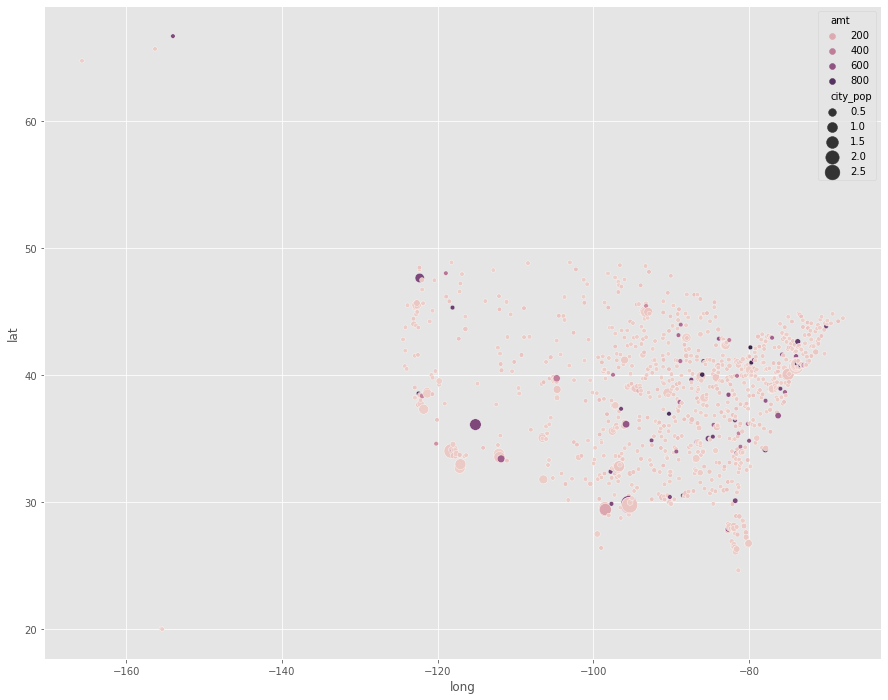

In [86]:
plt.figure(figsize=(15,12))

sns.scatterplot(data=train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index(),
                x='long' , y='lat', size='city_pop', hue='amt', sizes= (20,250));

### Gender

In [87]:
train_cleaned['gender'].value_counts(normalize=True)

F    0.547449
M    0.452551
Name: gender, dtype: float64

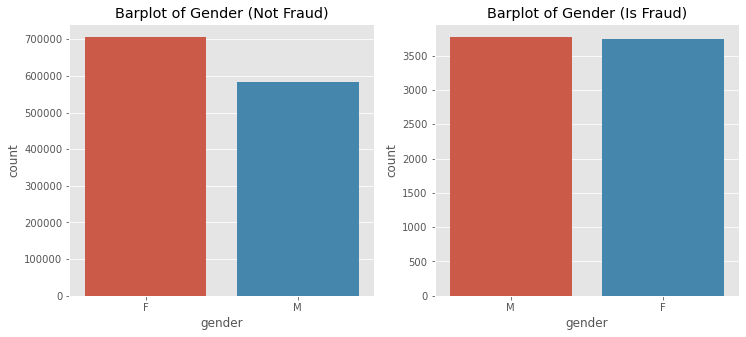

In [88]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='gender')
ax[0].set_title('Barplot of Gender (Not Fraud)')
sns.countplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='gender')
ax[1].set_title('Barplot of Gender (Is Fraud)');

### Category

In [89]:
order_cat_not_fraud = train_cleaned[train_cleaned['is_fraud']==0]['category'].value_counts().index
order_cat_is_fraud = train_cleaned[train_cleaned['is_fraud']==1]['category'].value_counts().index

cat_palette = ['red' if (i in range(4)) else 'grey' for i,x in enumerate(order_cat_is_fraud) ]

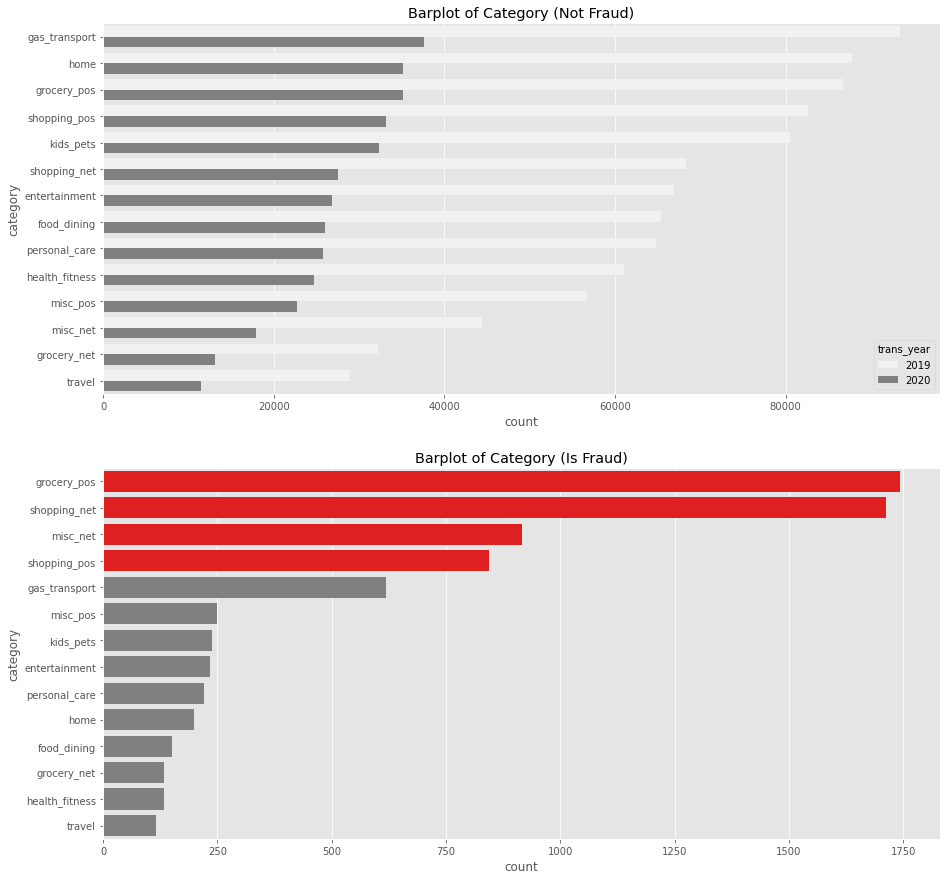

In [90]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
sns.countplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , y='category', 
              orient='h', order=order_cat_not_fraud, color='gray', hue='trans_year')
ax[0].set_title('Barplot of Category (Not Fraud)')

sns.countplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , y='category', 
              orient='h', order=order_cat_is_fraud, palette = cat_palette)
ax[1].set_title('Barplot of Category (Is Fraud)');

<AxesSubplot:xlabel='amt', ylabel='category'>

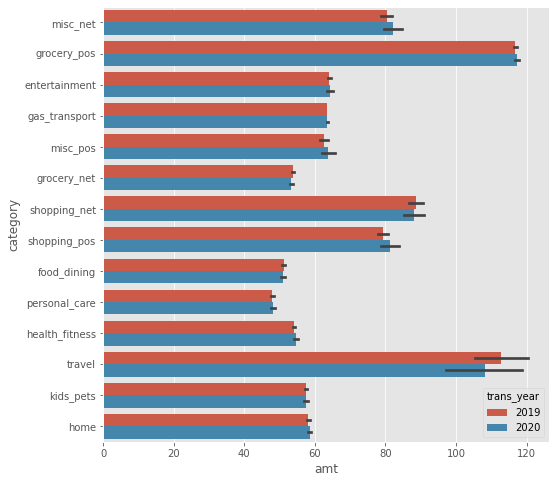

In [91]:
plt.figure(figsize=(8,8))
sns.barplot(y='category',x='amt', data=train_cleaned, hue='trans_year', orient='h')

In [92]:
pd.DataFrame(train_cleaned.groupby(['is_fraud','trans_year','category'])['amt'].mean())

amt
is_fraud trans_year category                   
0        2019       entertainment     63.055807
                    food_dining       51.073131
                    gas_transport     63.665411
                    grocery_net       53.928787
                    grocery_pos      114.121006
                    health_fitness    54.096298
                    home              57.887975
                    kids_pets         57.635355
                    misc_net          70.242970
                    misc_pos          62.189713
                    personal_care     47.964419
                    shopping_net      72.534270
                    shopping_pos      73.570528
                    travel           113.170035
         2020       entertainment     63.276246
                    food_dining       50.720194
                    gas_transport     63.701535
                    grocery_net       53.458126
                    grocery_pos      114.298384
                    health_fitness    54.576495
                    home              58.102204
                    kids_pets         57.583122
                    misc_net          70.646511
                    misc_pos          62.931576
                    personal_care     48.161977
                    shopping_net      71.168287
                    shopping_pos      74.990344
                    travel           108.340044
1        2019       entertainment    509.146380
                    food_dining      119.248558
                    gas_transport     12.376059
                    grocery_net       12.468404
                    grocery_pos      312.119817
                    health_fitness    20.256458
                    home             259.425659
                    kids_pets         17.885523
                    misc_net         795.827774
                    misc_pos         185.801882
                    personal_care     26.475592
                    shopping_net    1001.301765
                    shopping_pos     879.331784
                    travel             8.954070
         2020       entertainment    490.470429
                    food_dining      121.910000
                    gas_transport     12.072737
                    grocery_net       11.444750
                    grocery_pos      311.700333
                    health_fitness    20.227568
                    home             253.706522
                    kids_pets         18.727910
                    misc_net         799.619196
                    misc_pos         287.308750
                    personal_care     25.488676
                    shopping_net     994.453691
                    shopping_pos     871.517923
                    travel             9.381333

In [93]:
train_cleaned.groupby(['is_fraud','category'])['amt'].mean().to_frame().unstack().T

is_fraud                     0           1
    category                              
amt entertainment    63.118913  503.535579
    food_dining      50.972816  120.076954
    gas_transport    63.675782   12.288204
    grocery_net      53.792817   12.162836
    grocery_pos     114.172234  311.989616
    health_fitness   54.234775   20.248421
    home             57.949319  257.432626
    kids_pets        57.620386   18.121674
    misc_net         70.359176  797.012852
    misc_pos         62.401757  218.284080
    personal_care    48.020643   26.170545
    shopping_net     72.142606  999.254939
    shopping_pos     73.977575  876.921815
    travel          111.798920    9.064569

In [94]:
train_cleaned[train_cleaned['is_fraud']==1]['category'].value_counts(normalize=True)

grocery_pos       0.232214
shopping_net      0.228217
misc_net          0.121902
shopping_pos      0.112310
gas_transport     0.082334
misc_pos          0.033307
kids_pets         0.031841
entertainment     0.031042
personal_care     0.029310
home              0.026379
food_dining       0.020117
grocery_net       0.017852
health_fitness    0.017719
travel            0.015454
Name: category, dtype: float64

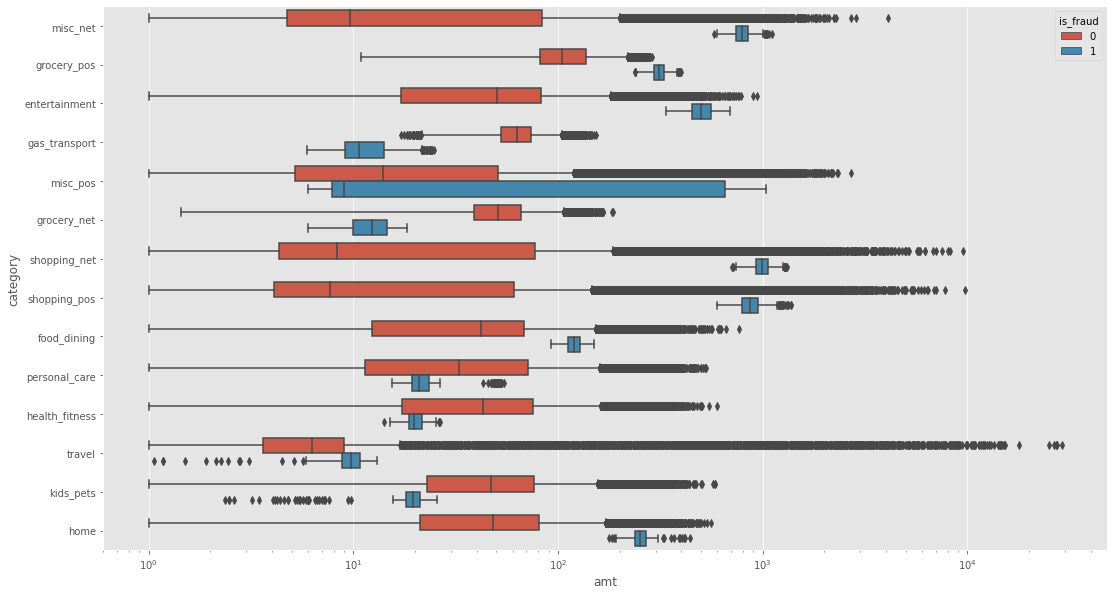

In [95]:
plt.figure(figsize=(18,10))
g= sns.boxplot(data=train_cleaned, x='amt', y='category', orient='h', hue='is_fraud')
g.set_xscale("log");

### Age

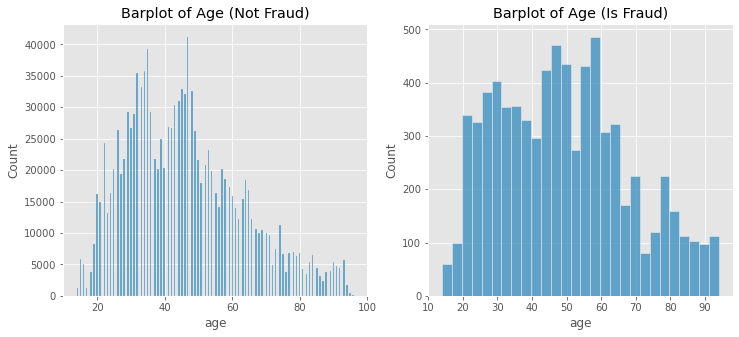

In [96]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='age')
ax[0].set_title('Barplot of Age (Not Fraud)')
sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='age')
ax[1].set_title('Barplot of Age (Is Fraud)');

In [97]:
train_cleaned['is_fraud'].unique()

array([0, 1], dtype=int64)

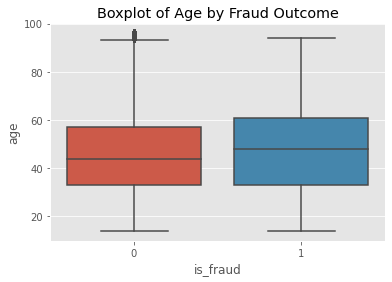

In [98]:
# plot boxplot on `age`
sns.boxplot(data=train_cleaned, x='is_fraud', y='age')
plt.title('Boxplot of Age by Fraud Outcome');

### Amount

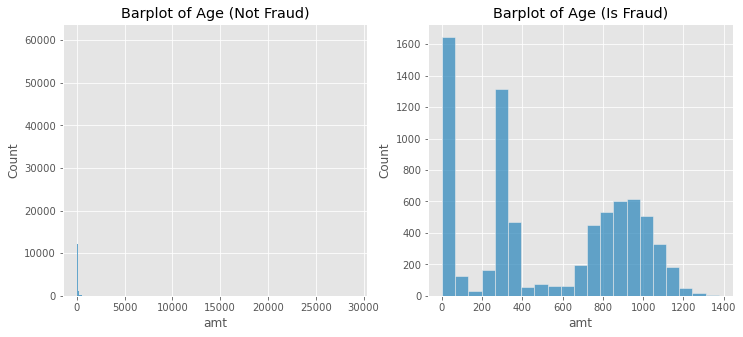

In [99]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='amt')
ax[0].set_title('Barplot of Age (Not Fraud)')
sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='amt')
ax[1].set_title('Barplot of Age (Is Fraud)');

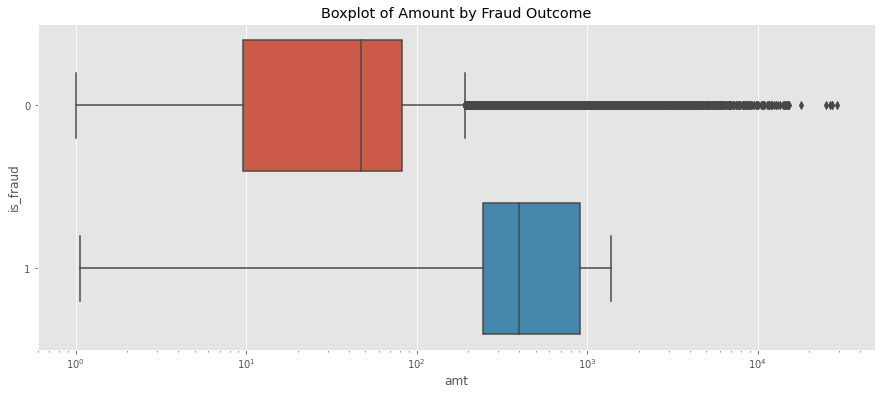

In [100]:
# plot boxplot on `age`
plt.figure(figsize=(15,6))
sns.boxplot(data=train_cleaned, y='is_fraud', x='amt', orient='h').set_xscale('log')
plt.title('Boxplot of Amount by Fraud Outcome');

<AxesSubplot:xlabel='trans_hour', ylabel='amt'>

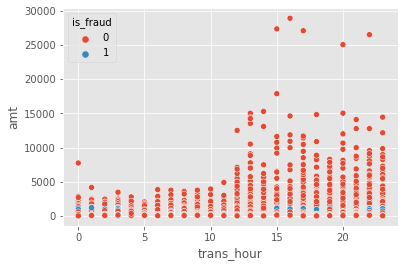

In [101]:
sns.scatterplot(data=train_cleaned, y='amt', x='trans_hour', hue='is_fraud')

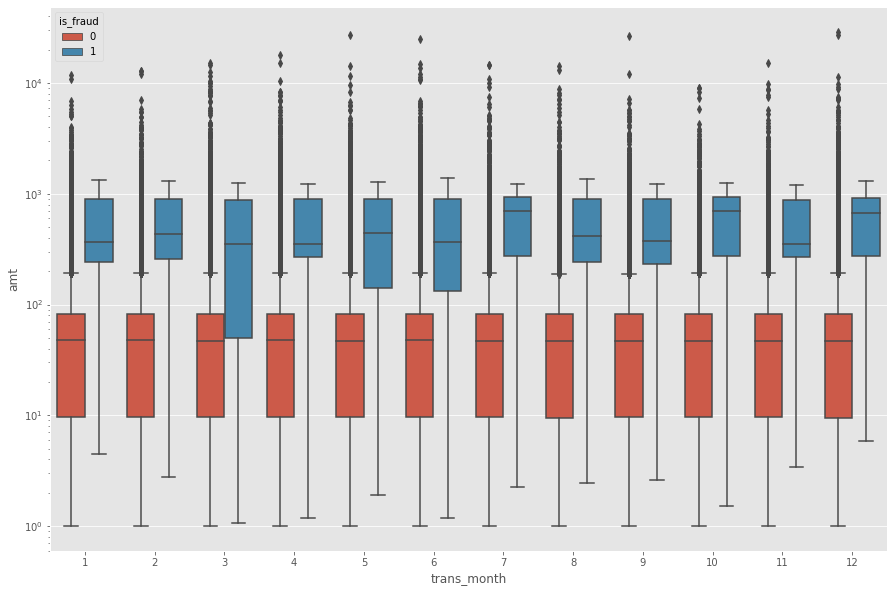

In [102]:
plt.figure(figsize=(15,10))
sns.boxplot(data=train_cleaned, y='amt', x='trans_month', hue='is_fraud').set_yscale('log')

### Testing Sample Credit Card

In [103]:
#testing here 571365235126
test_cc = train_cleaned[train_cleaned['cc_num'] == 571365235126]

In [104]:
test_cc.head(2)

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,amt_group
85,2019-01-01 01:02:53,571365235126,fraud_VonRueden_Group,grocery_net,89.35,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,...,2019,1,1,1,1,2,1,24,72.296100,"(83.14, 136.67]"
1045,2019-01-01 13:04:25,571365235126,"fraud_Swaniawski,_Nitzsche_and_Welch",health_fitness,177.82,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,...,2019,1,1,1,13,4,1,24,88.995243,"(136.67, 28948.9]"


In [105]:
# NetworkX to create and work with Networks
import networkx as nx

# Pyvis to visualise the graps from Networkx
from pyvis.network import Network

import itertools

In [106]:
test_cc['cc_num'].unique()[0]

571365235126

In [107]:
test_cc['category'].nunique()

14

In [108]:
test_cc.loc[test_cc['cc_num']==571365235126, 'category'].values.tolist()

['grocery_net',
 'health_fitness',
 'shopping_net',
 'health_fitness',
 'shopping_pos',
 'gas_transport',
 'kids_pets',
 'gas_transport',
 'shopping_net',
 'kids_pets',
 'misc_net',
 'gas_transport',
 'gas_transport',
 'misc_net',
 'gas_transport',
 'grocery_pos',
 'grocery_pos',
 'home',
 'gas_transport',
 'grocery_pos',
 'grocery_pos',
 'gas_transport',
 'grocery_pos',
 'misc_net',
 'shopping_net',
 'shopping_net',
 'health_fitness',
 'misc_pos',
 'entertainment',
 'entertainment',
 'misc_pos',
 'grocery_pos',
 'personal_care',
 'grocery_pos',
 'grocery_pos',
 'misc_net',
 'gas_transport',
 'gas_transport',
 'gas_transport',
 'entertainment',
 'personal_care',
 'health_fitness',
 'gas_transport',
 'misc_pos',
 'health_fitness',
 'misc_pos',
 'grocery_net',
 'health_fitness',
 'health_fitness',
 'shopping_net',
 'grocery_net',
 'health_fitness',
 'kids_pets',
 'kids_pets',
 'shopping_pos',
 'personal_care',
 'home',
 'misc_pos',
 'shopping_pos',
 'personal_care',
 'grocery_pos',
 'gas

In [1]:
## Network Analysis
# merchant_edges = []
# network_list = []

# for group in test_cc['cc_num'].unique():

#     # Find all the project members belonging to the group
#     cc_merchant = test_cc.loc[test_cc['cc_num']==group, 'merchant'].values.tolist()
#     # print(cc_merchant)

#     # Convert the list of project members to a 2x2 grouping
#     # This is the format NetworkX requires to build a graph
#     merchant_edges += list(itertools.combinations(cc_merchant, 2))
#     # print(merchant_edges)
    


# # Draw the network
# cc_net = nx.Graph()
# cc_net.add_edges_from(merchant_edges)
# network_list.append(cc_net)    

# cc_net = Network(notebook=True, width='100%')
# cc_net.from_nx(network_list[0])
# # cc_net.show('g1.html')

In [ ]:
test_cc['is_fraud'].value_counts(normalize=True)

In [ ]:
test_cc['cc_num'].unique()

In [ ]:
test_cc['trans_hour'].unique()

In [ ]:
test_cc.groupby(['is_fraud','trans_hour'])['is_fraud'].count()

In [ ]:
test_cc.groupby(['is_fraud','trans_year','trans_month']).agg({'is_fraud':'count','amt':'mean','distance':'mean'})

In [ ]:
test_cc = test_cc.sort_values('trans_datetime') # ensure the data sorted by datetime

In [ ]:
fe_test_cc = test_cc[['trans_num','trans_datetime','amt','coords_merch']].copy()

In [ ]:
fe_test_cc['cum_sum'] = fe_test_cc['amt'].cumsum() #cumsum
fe_test_cc['diff'] = fe_test_cc['amt'].diff() #diff
fe_test_cc['pct_change'] = fe_test_cc['amt'].pct_change()
fe_test_cc['avg'] = fe_test_cc['amt'].expanding(1).mean()
fe_test_cc['pre_trans_datetime'] = fe_test_cc['trans_datetime'].shift(1)
fe_test_cc['pre_coords_merch'] = fe_test_cc['coords_merch'].shift(1).values
fe_test_cc['diff_pre_trans_datetime'] = (fe_test_cc['trans_datetime'] - fe_test_cc['pre_trans_datetime']) / np.timedelta64(1,'D')

In [ ]:
fe_test_cc['distance_diff'] = fe_test_cc.iloc[1:,:].apply(lambda row: calculate_distance(row['coords_merch'], row['pre_coords_merch']), axis=1)

In [ ]:
fe_test_cc.head()

In [ ]:
fe_test_cc['distance_diff'].min(), fe_test_cc['distance_diff'].max()

In [ ]:
sns.scatterplot(data=fe_test_cc, x='diff_pre_trans_datetime', y='distance_diff')

In [ ]:
test_cc = pd.merge(test_cc, fe_test_cc, on='trans_num')

In [ ]:
test_cc.head()

In [ ]:
# test_cc.set_index('trans_datetime').resample('M')['amt'].mean()

In [ ]:
# plt.figure(figsize=(12,8))
# plt.plot(test_cc.set_index('trans_datetime').resample('M')['amt'].count(), label='Amount')

In [ ]:
train_cleaned.groupby(['is_fraud','trans_year','trans_hour']).agg({'is_fraud':'count','amt':'mean'})

## Feature Engineering

In [110]:
# sort value by cc_num and follow by transaction datetime
train_cleaned = train_cleaned.sort_values(['cc_num','trans_datetime'])

In [111]:
print(f"Train_cleaned Shape before Feature Engineering: {train_cleaned.shape}")

Train_cleaned Shape before Feature Engineering: (1296675, 33)


In [112]:
cum_sum = []
amt_diff = []
pct_change = []
amt_avg = []
pre_trans_datetime = []
pre_coords_merch = []
diff_pre_trans_datetime = []


for cc in train_cleaned['cc_num'].unique():
    test_cc = train_cleaned[train_cleaned['cc_num'] == cc]
    fe_test_cc = test_cc[['trans_num','trans_datetime','amt','coords_merch']].copy()
    
    cum_sum.append(fe_test_cc['amt'].cumsum().values) #cumsum
    amt_diff.append(fe_test_cc['amt'].diff().values) #diff
    pct_change.append(fe_test_cc['amt'].pct_change().values) #percentage change in amt
    amt_avg.append(fe_test_cc['amt'].expanding(1).mean().values) #average of amount
    pre_trans_datetime.append(fe_test_cc['trans_datetime'].shift(1).values)
    pre_coords_merch.append(fe_test_cc['coords_merch'].shift(1).values)
    
cum_sum = np.concatenate(cum_sum, axis=0)
amt_diff = np.concatenate(amt_diff, axis=0)
pct_change = np.concatenate(pct_change, axis=0)
amt_avg = np.concatenate(amt_avg, axis=0)
pre_trans_datetime = np.concatenate(pre_trans_datetime, axis=0)
pre_coords_merch = np.concatenate(pre_coords_merch, axis=0)

In [113]:
train_cleaned['cum_sum'] = cum_sum
train_cleaned['amt_diff'] = amt_diff
train_cleaned['pct_change'] = pct_change
train_cleaned['amt_avg'] = amt_avg
train_cleaned['pre_trans_datetime'] = pre_trans_datetime
train_cleaned['pre_coords_merch'] = pre_coords_merch

In [114]:
train_cleaned['diff_pre_trans_datetime'] = (train_cleaned['trans_datetime'] - train_cleaned['pre_trans_datetime']) / np.timedelta64(1,'D')

In [115]:
def calculate_distance(ori, merch):
    return distance.distance(ori, merch).km

In [116]:
# create a distance column
train_cleaned['distance_diff'] = train_cleaned.dropna().apply(lambda row: calculate_distance(row['coords_merch'], 
                                                                                               row['pre_coords_merch']), axis=1)

In [117]:
train_cleaned.head()

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,pre_trans_datetime,pre_coords_merch,diff_pre_trans_datetime,distance_diff
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,127.629296,"(0.999, 7.75]",7.27,NaN,NaN,7.270,NaT,NaN,NaN,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,110.202992,"(47.52, 83.14]",60.21,45.67,6.281981,30.105,2019-01-01 12:47:15,"(43.974711, -109.741904)",0.831736,224.614202
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,21.841827,"(47.52, 83.14]",142.29,29.14,0.550434,47.430,2019-01-02 08:44:57,"(42.018766, -109.044172)",0.001840,105.117359
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,87.124420,"(7.75, 47.52]",177.08,-47.29,-0.576145,44.270,2019-01-02 08:47:36,"(42.961335, -109.157564)",0.160162,88.111679
2907,2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,74.352876,"(7.75, 47.52]",204.26,-7.61,-0.218741,40.852,2019-01-02 12:38:14,"(42.228227, -108.747683)",0.022593,132.827928


In [118]:
# verify and confirm the combination is valid
train_cleaned['diff_pre_trans_datetime'].min(), train_cleaned['diff_pre_trans_datetime'].max()

(0.0, 15.526284722222222)

In [119]:
# verify and confirm the combination is valid
train_cleaned['distance_diff'].min(), train_cleaned['distance_diff'].max()

(0.08060349136264632, 285.60722549053435)

In [120]:
# drop the pre_trans_datetime
train_cleaned.drop(['pre_trans_datetime','pre_coords_merch'], axis=1, inplace=True)

In [121]:
print(f"Train_cleaned Shape after Feature Engineering: {train_cleaned.shape}")

Train_cleaned Shape after Feature Engineering: (1296675, 39)


In [122]:
train_cleaned.head(3)

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_dayofweek,age,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,1,33,127.629296,"(0.999, 7.75]",7.27,NaN,NaN,7.270,NaN,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,110.202992,"(47.52, 83.14]",60.21,45.67,6.281981,30.105,0.831736,224.614202
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,21.841827,"(47.52, 83.14]",142.29,29.14,0.550434,47.430,0.001840,105.117359


In [133]:
train_cleaned = train_cleaned.replace(np.nan, 0)

In [135]:
train_cleaned.head()

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_dayofweek,age,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,1,33,127.629296,"(0.999, 7.75]",7.27,0.00,0.000000,7.270,0.000000,0.000000
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,110.202992,"(47.52, 83.14]",60.21,45.67,6.281981,30.105,0.831736,224.614202
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,21.841827,"(47.52, 83.14]",142.29,29.14,0.550434,47.430,0.001840,105.117359
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,87.124420,"(7.75, 47.52]",177.08,-47.29,-0.576145,44.270,0.160162,88.111679
2907,2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,74.352876,"(7.75, 47.52]",204.26,-7.61,-0.218741,40.852,0.022593,132.827928


In [138]:
train_cleaned['cc_num'][0]

2703186189652095

In [144]:
train_cleaned.set_index('trans_datetime').loc[train_cleaned.set_index('trans_datetime')['cc_num'] == train_cleaned['cc_num'][10]]['is_fraud'].value_counts()

0    2011
1      10
Name: is_fraud, dtype: int64

In [147]:
train_cleaned[(train_cleaned['is_fraud'] == 1) & (train_cleaned['cc_num']==train_cleaned['cc_num'][10])]

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_dayofweek,age,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
99275,2019-02-28 00:32:58,4642894980163,"fraud_Schaefer,_Maggio_and_Daugherty",gas_transport,10.13,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,114.940342,"(7.75, 47.52]",8232.03,-177.11,-0.945898,46.772898,0.128299,152.538295
99296,2019-02-28 01:04:52,4642894980163,"fraud_Raynor,_Feest_and_Miller",gas_transport,10.29,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,77.138332,"(7.75, 47.52]",8242.32,0.16,0.015795,46.566780,0.022153,42.001791
99319,2019-02-28 01:42:50,4642894980163,fraud_Kuphal-Predovic,misc_net,779.79,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,101.491480,"(136.67, 28948.9]",9022.11,769.50,74.781341,50.686011,0.026366,114.995888
99424,2019-02-28 04:06:40,4642894980163,fraud_Bartoletti-Wunsch,gas_transport,9.07,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,84.618729,"(7.75, 47.52]",9031.18,-770.72,-0.988369,50.453520,0.099884,82.690288
100400,2019-02-28 22:02:41,4642894980163,fraud_Conroy_Ltd,shopping_pos,747.73,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,90.486089,"(136.67, 28948.9]",9778.91,738.66,81.439912,54.327278,0.747234,162.948844
102206,2019-02-28 22:15:10,4642894980163,fraud_Fisher_Inc,shopping_net,1022.46,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,69.084406,"(136.67, 28948.9]",10801.37,274.73,0.367419,59.676077,0.008669,81.683003
100422,2019-02-28 22:26:03,4642894980163,fraud_Herman_Inc,misc_pos,8.66,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,93.782193,"(7.75, 47.52]",10810.03,-1013.80,-0.991530,59.395769,0.007558,161.321124
100427,2019-02-28 22:31:44,4642894980163,"fraud_Baumbach,_Feeney_and_Morar",shopping_net,946.02,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,117.961437,"(136.67, 28948.9]",11756.05,937.36,108.240185,64.240710,0.003947,184.095434
100432,2019-02-28 22:35:06,4642894980163,fraud_Jast_Ltd,shopping_net,1238.30,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,7.512031,"(136.67, 28948.9]",12994.35,292.28,0.308958,70.621467,0.002338,112.352272
102334,2019-02-28 23:28:13,4642894980163,"fraud_Monahan,_Hermann_and_Johns",travel,9.68,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,3,29,101.198283,"(7.75, 47.52]",13004.03,-1228.62,-0.992183,70.292054,0.036887,94.860271


In [139]:
train_cleaned.set_index('trans_datetime').loc[train_cleaned.set_index('trans_datetime')['cc_num'] == train_cleaned['cc_num'][0]]

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,...,trans_dayofweek,age,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
trans_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,2703186189652095,"fraud_Rippin,_Kub_and_Mann",misc_net,4.97,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,1,31,78.773821,"(0.999, 7.75]",4.97,0.00,0.000000,4.970000,0.000000,0.000000
2019-01-01 16:53:34,2703186189652095,fraud_Ruecker-Mayert,kids_pets,114.79,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,1,31,121.231332,"(83.14, 136.67]",119.76,109.82,22.096579,59.880000,0.703657,165.008123
2019-01-01 23:02:37,2703186189652095,fraud_Pacocha-Weissnat,kids_pets,16.55,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,1,31,108.226552,"(7.75, 47.52]",136.31,-98.24,-0.855824,45.436667,0.256285,148.990011
2019-01-03 01:40:38,2703186189652095,fraud_Kuhn_LLC,misc_net,27.70,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,3,31,96.477834,"(7.75, 47.52]",164.01,11.15,0.673716,41.002500,1.109734,138.617734
2019-01-03 15:24:11,2703186189652095,"fraud_Nicolas,_Hills_and_McGlynn",entertainment,43.72,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,3,31,122.740761,"(7.75, 47.52]",207.73,16.02,0.578339,41.546000,0.571910,184.313751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-20 02:02:33,2703186189652095,fraud_Herzog_Ltd,misc_pos,87.71,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,5,32,53.619819,"(83.14, 136.67]",177066.33,51.40,1.415588,87.483365,0.046782,35.182333
2020-06-20 20:57:37,2703186189652095,fraud_Harris_Group,food_dining,8.76,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,5,32,105.870776,"(7.75, 47.52]",177075.09,-78.95,-0.900125,87.444489,0.788241,97.639282
2020-06-21 01:43:26,2703186189652095,fraud_Huels-Nolan,gas_transport,50.45,F,561 Perry Cove,Moravian_Falls,NC,28654,36.0788,...,6,32,18.555116,"(47.52, 83.14]",177125.54,41.69,4.759132,87.426229,0.198484,113.157863


In [222]:
train_cleaned.head(2)

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_dayofweek,age,distance,amt_group,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,1,33,127.629296,"(0.999, 7.75]",7.27,0.00,0.000000,7.270,0.000000,0.000000
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,2,33,110.202992,"(47.52, 83.14]",60.21,45.67,6.281981,30.105,0.831736,224.614202


In [232]:
train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D').agg({'diff_pre_trans_datetime':['mean','count']}).sort_values([('diff_pre_trans_datetime','mean')]).head(10)

diff_pre_trans_datetime      
                                  mean count
trans_datetime                              
2019-02-18                    0.045741     1
2019-12-28                    0.079537    13
2019-12-01                    0.081618    13
2019-12-09                    0.084257    12
2019-12-02                    0.085096    11
2019-06-30                    0.087341    14
2019-12-29                    0.091309    11
2019-12-23                    0.091523     8
2019-12-30                    0.095034    10
2019-12-15                    0.095553    10

In [224]:
train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')[['diff_pre_trans_datetime','amt']].mean().sort_values('diff_pre_trans_datetime',ascending=True).head(20)

,diff_pre_trans_datetime,amt
trans_datetime,,
2019-02-18,0.045741,69.060000
2019-12-28,0.079537,151.474615
2019-12-01,0.081618,64.030000
2019-12-09,0.084257,42.571667
2019-12-02,0.085096,41.386364
2019-06-30,0.087341,49.751429
2019-12-29,0.091309,56.920000
2019-12-23,0.091523,47.111250
2019-12-30,0.095034,261.238000


In [ ]:
(train_cleaned['cc_num']==train_cleaned['cc_num'][10]) & (train_cleaned['']) 

In [172]:
train_cleaned[(train_cleaned['cc_num']==train_cleaned['cc_num'][10])].\
groupby(['trans_year','trans_month','trans_day']).agg({'amt':['mean','count']})

amt      
                                        mean count
trans_year trans_month trans_day                  
2019       1           1           34.815000     8
                       2           29.164000     5
                       3           51.950000     1
                       5           52.876667     6
                       6           36.493333     3
...                                      ...   ...
2020       6           16          39.725000     4
                       17         144.014000     5
                       18          69.672500     4
                       19          42.585000     2
                       20          38.102500     8

[514 rows x 2 columns]

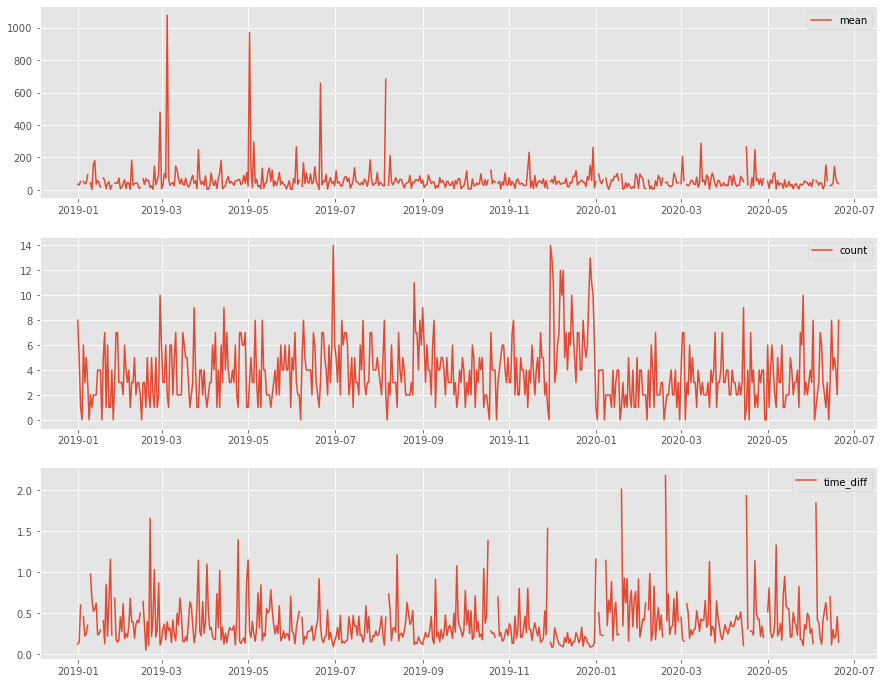

In [221]:
fig, axes = plt.subplots(nrows=3, figsize=(15,12))
axes[0].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['amt'].mean(), 
             label='mean')
axes[0].legend()

axes[1].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['amt'].count(), 
             label='count')
axes[1].legend()

axes[2].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['diff_pre_trans_datetime'].mean(), 
             label='time_diff')
axes[2].legend();

## Exploratory Data Analysis (EDA)

In [83]:
# use heatmap to find the correlation
def plot_heatmap(df):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title('Correlation Heatmap for Merged Data', fontsize=22);

C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/1081814344.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


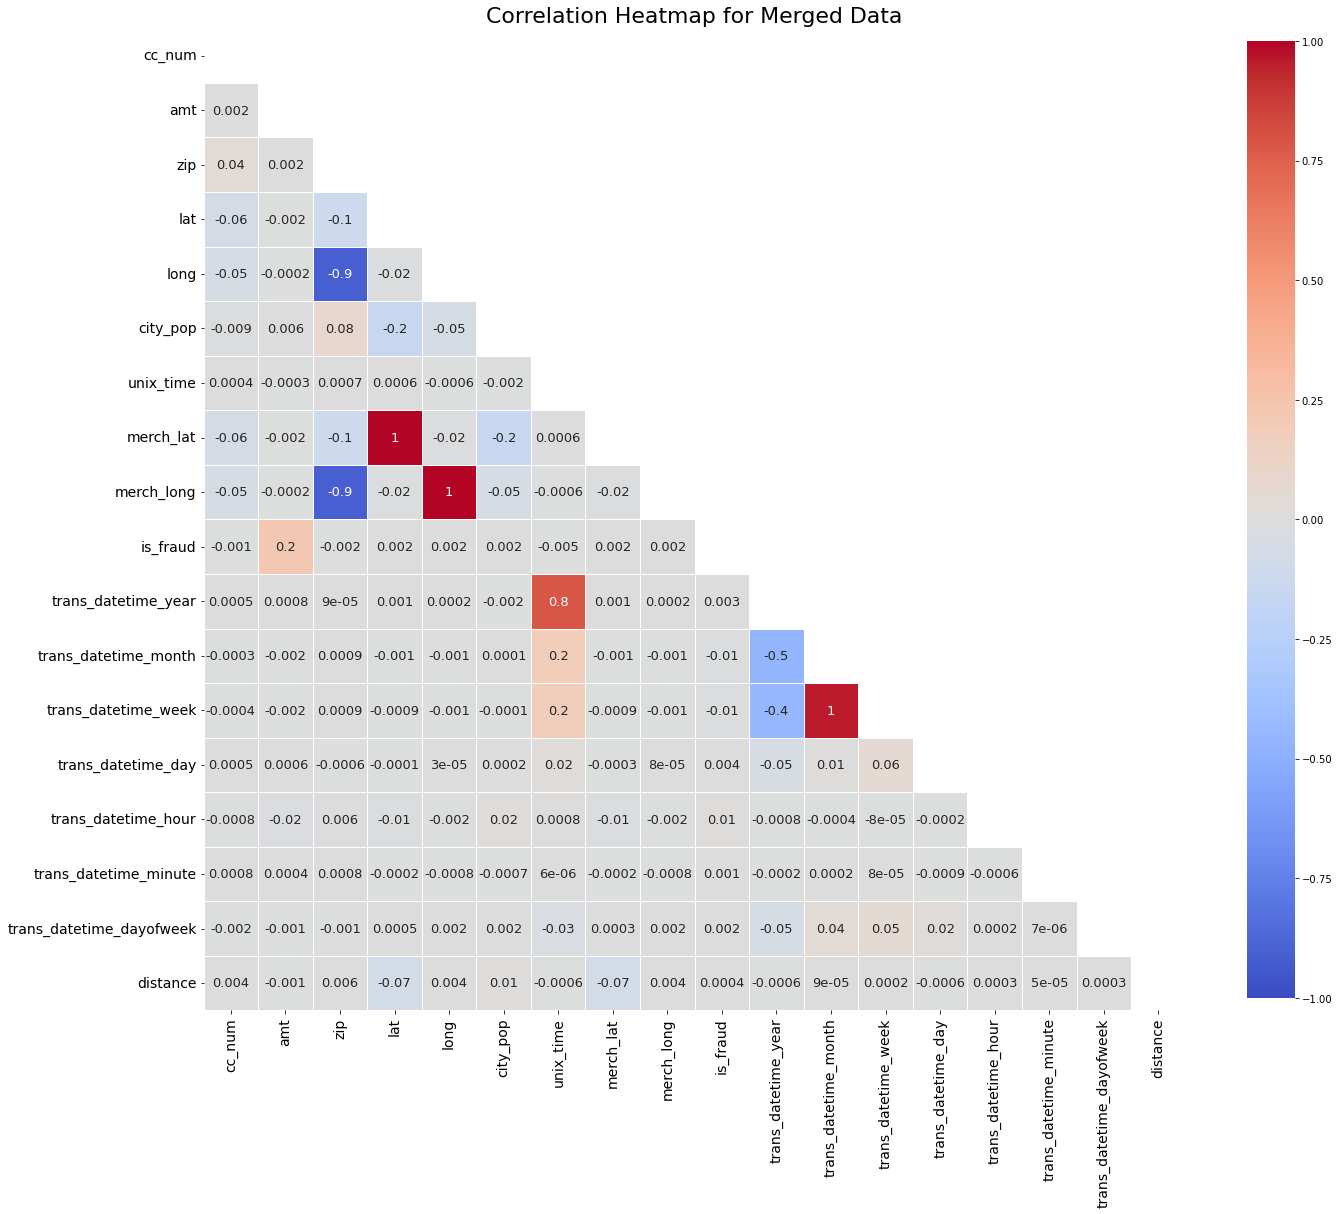

In [84]:
plot_heatmap(train_cleaned)

In [69]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'name', 'coords_ori', 'coords_merch', 'trans_datetime_year',
       'trans_datetime_month', 'trans_datetime_week', 'trans_datetime_day',
       'trans_datetime_hour', 'trans_datetime_minute',
       'trans_datetime_dayofweek', 'unix_time_conv', 'distance'],
      dtype='object')

In [70]:
train_cleaned[train_cleaned['is_fraud'] == 1]['cc_num'].value_counts()

4593569795412          19
3520550088202337       19
4260128500325          18
4400011257587661852    16
3518669219150142       16
                       ..
4503101193493052864     2
4089096483689733451     2
6011109736646996        2
4809701904914           2
4005676619255478        2
Name: cc_num, Length: 762, dtype: int64

In [32]:
train_cleaned[train_cleaned['cc_num'] == 4613314721966]['is_fraud'].value_counts(normalize=True)

0    0.994712
1    0.005288
Name: is_fraud, dtype: float64

In [ ]:
train_cleaned = train_cleaned[train_cleaned['cc_num'] == 4613314721966]

In [77]:
train_cleaned[train_cleaned['cc_num'] == 3518669219150142]['is_fraud'].value_counts(normalize=True)

0    0.993663
1    0.006337
Name: is_fraud, dtype: float64

In [78]:
train_cleaned_1 = train_cleaned[train_cleaned['cc_num'] == 3518669219150142]

In [75]:
train_cleaned_1.shape

(1546, 32)

In [35]:
def plot_clusters(df, name):
    ax = df.plot(kind="scatter", x="distance", y="amt", c ='is_fraud', colormap='tab20', figsize=(12,6), s=50)
   
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.title(f"Scatter Plot for {name}")
    ax.tick_params(axis='both', which='major', labelsize=18)
    return plt.show()

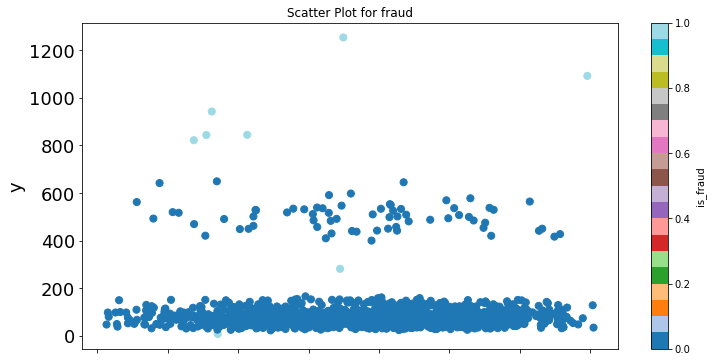

In [36]:
plot_clusters(train_cleaned[['amt','distance','is_fraud']], 'fraud')

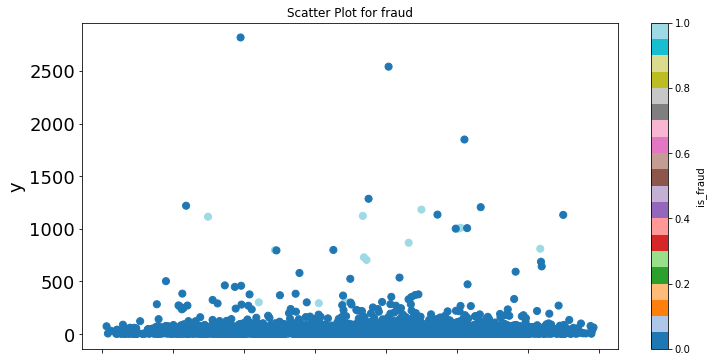

In [79]:
plot_clusters(train_cleaned_1[['amt','distance','is_fraud']], 'fraud')

In [37]:
# Write your function to scale data here.
def scale_matrix(X):
    sc = StandardScaler()
    X_sc = sc.fit_transform(X)
    return X_sc


In [38]:
# Write a function that will plot the results of the three
# clustering algorithms for comparison.

# Your function should take TWO INPUTS:
# 1 - The data
# 2 - The clusterer

# Your function should do TWO THINGS:
# 1 - Print the SILHOUETTE SCORE for your clusters
# 2 - Plot the clusteres with appropriate coloring

def plot_results(df, cl):
    
    # Scale data
    X = df[['distance','amt']]
    X_sc = scale_matrix(X)
    
    # Fit clusterer
    #clusterer = cl(random_state=42)
    cl.fit(X_sc)
    df['is_fraud'] = cl.labels_
    
    # Print Silhouette Score
    print(f"Silhouette Score: {silhouette_score(X_sc, cl.labels_)}")
    
    # Plot    
    ax = df.plot(kind="scatter", x="distance", y="amt", c= 'is_fraud', colormap='tab20', figsize=(12,6), s=50)
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.title(f"Scatter Plot for")
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    return plt.show()

Silhouette Score: 0.7234493212460253


C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/420973840.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_fraud'] = cl.labels_


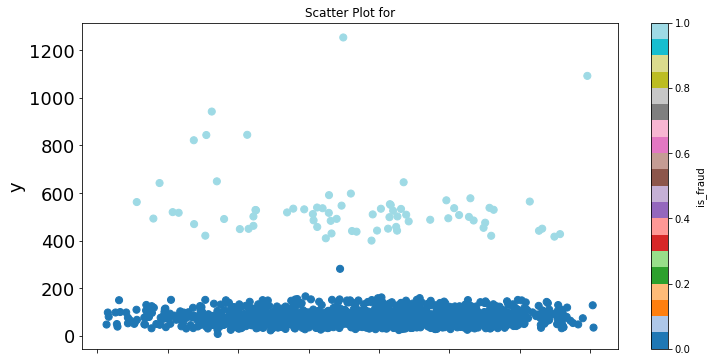

In [39]:
# A:
cl = KMeans(n_clusters = 2, random_state=42)

plot_results(train_cleaned[['amt','distance','is_fraud']], cl)

C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/420973840.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_fraud'] = cl.labels_


Silhouette Score: 0.4646397299447482


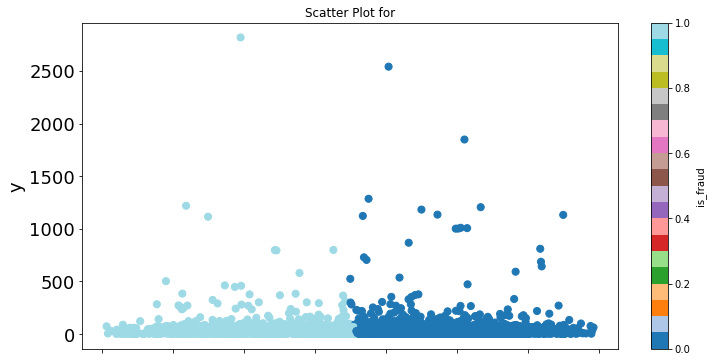

In [81]:
# A:
cl = KMeans(n_clusters = 2, random_state=42)

plot_results(train_cleaned_1[['amt','distance','is_fraud']], cl)

Silhouette Score: 0.7005662233537445


C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/420973840.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_fraud'] = cl.labels_


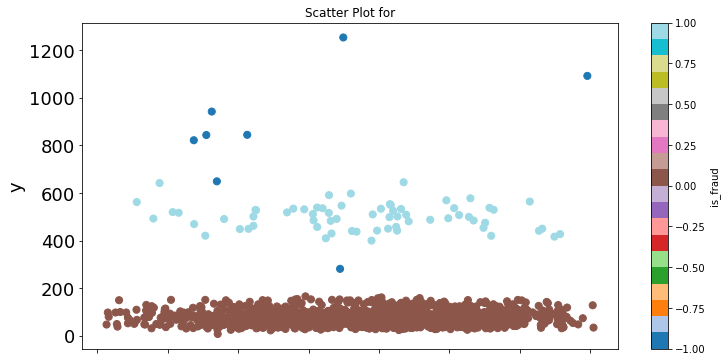

In [61]:
dbscan = DBSCAN(eps=1.1, min_samples=5)

plot_results(train_cleaned[['amt','distance','is_fraud']], dbscan)

C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/420973840.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_fraud'] = cl.labels_


Silhouette Score: 0.763679746588745


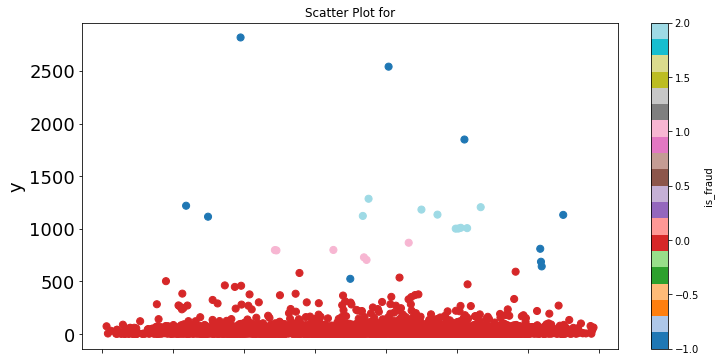

In [80]:
dbscan = DBSCAN(eps=1.1, min_samples=5)

plot_results(train_cleaned_1[['amt','distance','is_fraud']], dbscan)

Silhouette Score: 0.7234493212460253


C:\Users\chua_\AppData\Local\Temp/ipykernel_20296/420973840.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_fraud'] = cl.labels_


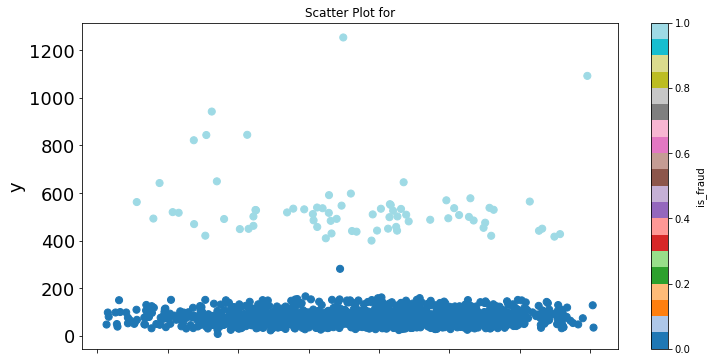

In [60]:
ac = AgglomerativeClustering()

plot_results(train_cleaned[['amt','distance','is_fraud']], ac)

### Export Data

In [335]:
# save to pickle file
train_cleaned.to_pickle('../datasets/train_final.pkl')